# Chest X-ray Classification using CNN

This project aims to classify chest X-rays as normal or abnormal using a convolutional neural network (CNN).

Dataset: NIH Chest X-ray dataset from Kaggle.

## 1. Import Libraries
Importing necessary Python libraries for data processing, visualization, model building, and evaluation.


In [ ]:
import os
import shutil
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Mounted at /content/drive


Uploading model and sample image

In [ ]:
from google.colab import files

# Prompt to upload model
print("Please upload the trained model (.h5) file:")
uploaded = files.upload()

# Prompt to upload sample image
print("Please upload a sample chest X-ray image:")
uploaded = files.upload()

## 2. Configure Logging
Setting up logging to track progress and record key steps during the training and evaluation process.

In [ ]:
# Keep track of progress and debug during training and preprocessing
logging.basicConfig(
    filename='training_log.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logging.info("Logging initialized successfully.")

## 3. Load Dataset
Loading the NIH Chest X-ray dataset CSV file containing image labels and metadata.

In [ ]:
# Define separate paths for labels and images
labels_path = os.path.join("data", "archive", "Data_Entry_2017.csv")  # Path for CSV file, <-- change this to match locally downloaded dataset
images_path = os.path.join("data", "images")  # Path for actual images, <-- change this to match locally downloaded dataset

# Load the labels CSV file
logging.info(f"Loading labels from: {labels_path}")
df = pd.read_csv(labels_path)
logging.info("labels loaded successfully")

# Show first few rows of the dataset
print("Dataset Shape:", df.shape)
print(df.head())


Dataset Shape: (112120, 12)
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                      

## 4. Check for Missing Values
Checking for any missing values in the dataset to ensure data quality before preprocessing.

In [ ]:
# Checking for any missing data to ensure data integrity.
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112120
dtype: int64


In [ ]:
# Drop unnamed column
df = df.drop(columns=['Unnamed: 11'])
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
dtype: int64


## 5. Simplify Target Labels
Simplifying the multi-label classification to binary: Normal vs. Abnormal to make the problem more manageable.

In [ ]:
# We simplify the multi-label classification to binary: Normal vs Abnormal
df['Target'] = df['Finding Labels'].apply(lambda x: 'Normal' if x == 'No Finding' else 'Abnormal')

## 6. Visualize Class Distribution
Plotting class distribution to understand the balance between Normal and Abnormal cases in the dataset.

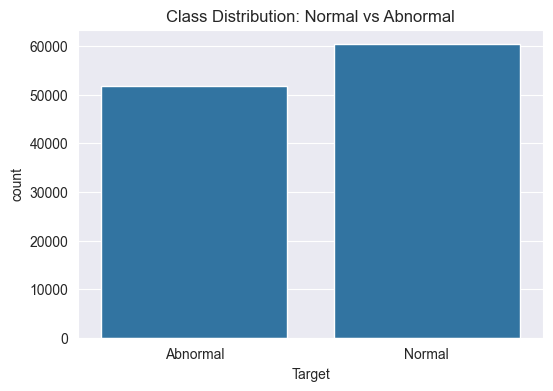

In [ ]:
# Looking at class balance to detect potential imbalances in the data that might affect training
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Target')
plt.title("Class Distribution: Normal vs Abnormal")
plt.show()

## 7. Display Sample Images
Visualizing sample chest X-ray images to get an idea of the data quality and characteristics

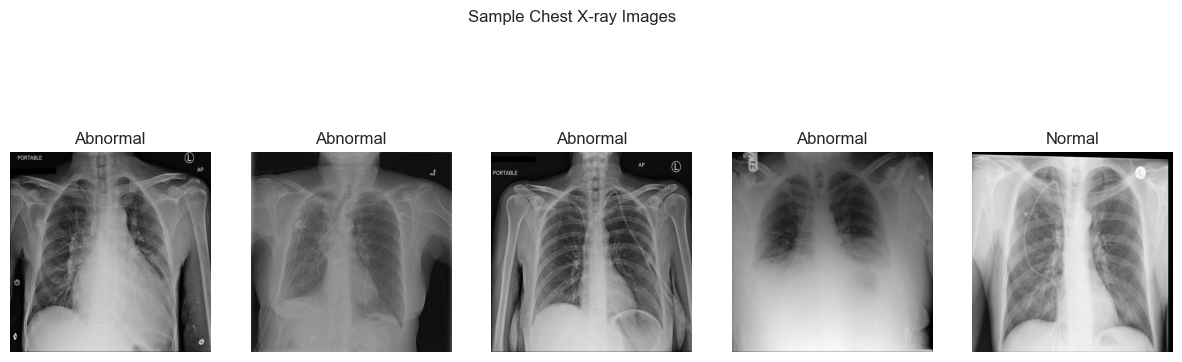

In [ ]:
# Visualizing sample chest X-ray images to get an idea of the data quality and characteristics
sample_images = df.sample(5)
plt.figure(figsize=(15,5))
for i, row in enumerate(sample_images.iterrows()):
    img_path = os.path.join(images_path, row[1]['Image Index'])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(row[1]['Target'])
    plt.axis('off')
plt.suptitle("Sample Chest X-ray Images")
plt.show()

## 8. Data Preprocessing
Before feeding images into the CNN, we need to do the following:
- Convert grayscale X-ray images to a standard format
- Resize images to a fixed size (128x128) for consistent input shape
- Normalize pixel values (0 to 1)
- Split dataset into Training and Testing sets to evaluate model performance

We will also be utilizing a data generator approach to split images into batches to save on RAM space

In [ ]:
# Move images into respective class folders to use with ImageDataGenerator
# Create directories if they don't exist
for split in ['train', 'test']:
    for label in ['Normal', 'Abnormal']:
        os.makedirs(os.path.join('data', split, label), exist_ok=True)

# Split dataset into train and test (80/20 split)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Target'], random_state=42)

# Move images
logging.info("Organizing images into folders...")

def move_images(subset_df, subset_name):
    for _, row in subset_df.iterrows():
        label = row['Target']
        src_path = os.path.join(images_path, row['Image Index'])
        dest_path = os.path.join('data', subset_name, label, row['Image Index'])
        if os.path.exists(src_path) and not os.path.exists(dest_path):
            shutil.copy2(src_path, dest_path)

move_images(train_df, 'train')
move_images(test_df, 'test')

logging.info("Images successfully organized into train and test folders.")

In [ ]:
# Using ImageDataGenerator to load images in batches, apply preprocessing, and feed them into the model. This will save on main memory usage
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    subset='training'
)
logging.info(f"Training generator created. {train_generator.samples} images found.")

val_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    subset='validation'
)
logging.info(f"Validation generator created. {val_generator.samples} images found.")

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
logging.info(f"Test generator created. {test_generator.samples} images found.")

Found 71758 images belonging to 2 classes.
Found 17938 images belonging to 2 classes.
Found 22424 images belonging to 2 classes.


## 9. Build CNN Model
Building a convolutional neural network (CNN) designed to classify chest X-rays as Normal or Abnormal.

In [ ]:
# Defining the convolutional neural network (CNN) for binary classification.
# CNN architecture based on Keras official documentation example:
# TensorFlow/Keras Documentation. (n.d.). Convolutional Neural Network (CNN). https://www.tensorflow.org/tutorials/images/cnn

def build_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_model()
logging.info("CNN model built.")
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

## 10. Train Model using Generators
Training the CNN model using batch generators.

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)
logging.info("Model training completed.")

## 11. Evaluate Model
Evaluating the model on the test dataset and generating classification reports and confusion matrix for performance assessment.

701/701 [==============================] - 437s 624ms/step - loss: 0.6341 - accuracy: 0.6510
Test Loss: 0.6341, Test Accuracy: 0.6510
701/701 [==============================] - 159s 226ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.55      0.59     10352
           1       0.66      0.74      0.69     12072

    accuracy                           0.65     22424
   macro avg       0.65      0.64      0.64     22424
weighted avg       0.65      0.65      0.65     22424



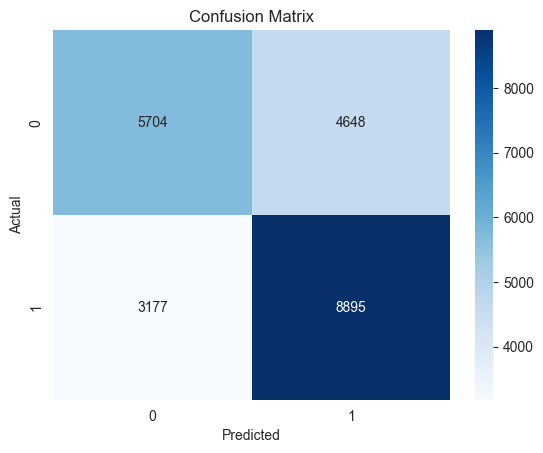

In [ ]:
# Assessing model performance on the test set using classification report and confusion matrix

loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predictions
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(test_generator.classes, y_pred))

cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 12. Plot Training History
Visualizing the model's training and validation accuracy and loss trends over epochs.

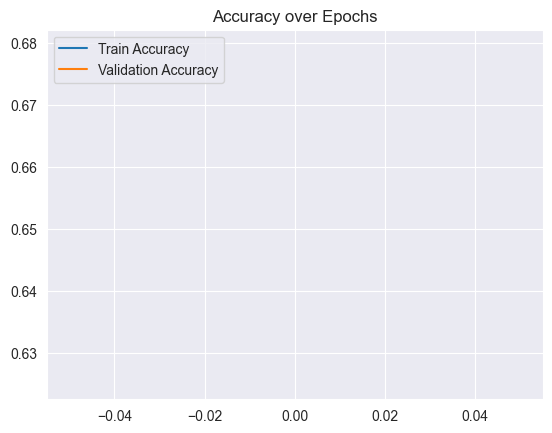

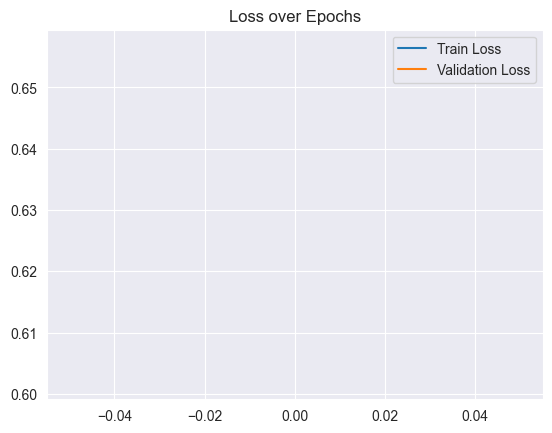

In [ ]:
# Visualizing training and validation accuracy and loss over epochs

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc = "upper left")
plt.title('Accuracy over Epochs')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc = "upper right")
plt.title('Loss over Epochs')
plt.show()

## 13. Save/Load Model
Saving the trained model in HDF5 format for future inference and evaluation.
Option to Load Model between sessions.

In [ ]:
# Saving the trained model for future use
model.save("cnn_xray_model.h5")
logging.info("Model saved successfully.")

In [ ]:
# Load the saved model
model_path = "cnn_xray_model.h5"
model = load_model(model_path) # May receive errors due to loading without compiling or training model
logging.info("Model loaded successfully!")

## 14. User Prediction Function
Providing a user-friendly function for inputting new chest X-ray images and getting classification results along with confidence scores. The function also displays the image visually.

In [ ]:
def predict_new_image(image_path):
    # Load and preprocess image
    img = image.load_img(image_path, target_size=(128, 128), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array_norm = img_array / 255.0
    img_array_norm = img_array_norm.reshape(1, 128, 128, 1)

    # Make prediction
    prediction = model.predict(img_array_norm)
    probability = float(prediction[0][0])
    result = 'Abnormal' if probability > 0.5 else 'Normal'

    # Display image
    plt.imshow(img_array.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f"Prediction: {result}\nProbability: {probability:.4f}")
    plt.show()

    print(f"Prediction: {result} (Probability: {probability:.4f})")
    return result, probability

## 15. Model Prediction Function
Function prepared for user and ready to execute. replacing sample_image_path location will allow user to change image model is predicting.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


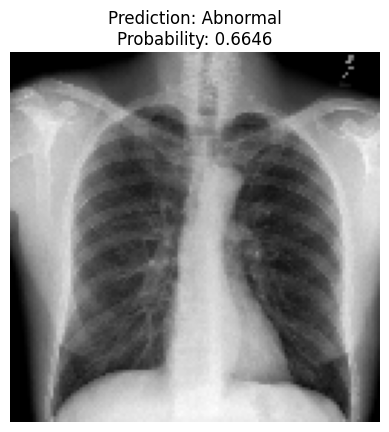

Prediction: Abnormal (Probability: 0.6646)


('Abnormal', 0.6645877957344055)

In [ ]:
# Load the saved model
model_path = "cnn_xray_model.h5"
sample_image_path = "sample_image0.png"

model = load_model(model_path, compile=False)
logging.info("Model loaded successfully!")

# Run model on test image, user can change location if they have a different image to run
predict_new_image(sample_image_path)